# Introduction

<b>Group B</b>   | <b>Team 8</b> <br> 
<b>Student Name</b>   | <b>Student ID</b> <br> 

Zheng Ju | 16205656 <br>
Royal Thomas | 16326926 <br>
Ga Jun Young | 16440714 <br>

<br>
The following is a notebook outlining the steps to build a deep learning sentiment analysis model based on the dataset from:
<a href="https://https://www.kaggle.com/kazanova/sentiment140">https://https://www.kaggle.com/kazanova/sentiment140</a>

<br>
<br>
<b>Note</b>: Originally, the notebook was intended for Kaggle Notebook usage due to TPU (30hours per 3 days) availability which decreases the training time. 
A setup can be found here: https://www.kaggle.com/docs/tpu. This reduced the training time of the model by 94%! But due to assignment restriction we have removed the code to train under the TPU. 
Under the TPU, it would take less than 1 min per epoch. But depending on personal GPU or CPU, it takes approximately 18 mins per epoch - Google Colab GPU.

We have moved away from that aspect and the notebook can now be deployed locally.

<br>
<br>
In order to create the model <b>5 major steps</b> are involved:

<ol>
    <li>Tweet Preprocessing</li>
    <li>Text Representation</li>
    <li>Generate Embedding Matrix</li>
    <li>Modelling</li>
    <li>Deployment</li>
</ol>

# Setup Project

## `Install requirements`

Specific requirements are necessary to preprocess, embed, and construct the deep learning model.

In [ ]:
# Install the requirements 
# IMPORTANT: Sometimes you'll face errors using just pip, try using pip3! 
!pip install -r requirements.txt

## `Import libraries`

In [8]:
# DataFrame
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas() # visible progress bar

# Matplot
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from tensorflow import keras  

# keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, MaxPooling1D, Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, concatenate, SpatialDropout1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Utility
import numpy as np
import string 
import os
import os.path
from os import path
from collections import Counter
import re
import contractions
import gc #collect memory

## `Instantiate Constant variables`

In [3]:
# DataFrame
DATASET_FIELDS = ['target', 'ids', 'date', 'flag', 'user', 'text']
PREPROCESSED_DATASET_FIELDS = ['target', 'text']
DATASET_ENCODING = 'ISO-8859-1'
DATASET_FILEPATH = 'training.1600000.processed.noemoticon.csv'
TRAIN_SIZE = 0.8
RANDOM_SEED = 0

# Decode Target
DECODE_MAP = {0: 'negative', 2: 'neutral', 4: 'positive'}

# Tokenizer
MAX_FEATURES = 20000 
MAX_LENGTH = 300

#os 
USERNAME = "gajunyoung" # username from the json file
KEY = "8fcfb8936176f2c15c331c4b574bf7e5" # key from the json file

# Embedding files
EMBEDDING_FILES = [
    'crawl-300d-2M.vec',
    'glove.840B.300d.txt'
]


## `Download the dataset and pre-trained embeddings from Kaggle`

The dataset is from Sentiment140

The pre-trained embeddings are GloVe and fastText

In [6]:
os.environ['KAGGLE_USERNAME'] = USERNAME # username from the json file
os.environ['KAGGLE_KEY'] = KEY # key from the json file


if(not path.exists(DATASET_FILEPATH)):
    # Download the dataset 
    !kaggle datasets download -d kazanova/sentiment140

    #unzip the sentiment file
    !unzip -q sentiment140.zip

def download_word_vectors():
    # Download glove if doesn't already exist
    if(not path.exists(EMBEDDING_FILES[1])):
        !kaggle datasets download -d takuok/glove840b300dtxt
        !unzip -q glove840b300dtxt.zip
    
    # Download FastText if doesn't already exist.
    if(not path.exists(EMBEDDING_FILES[0])):
        !kaggle datasets download -d  yekenot/fasttext-crawl-300d-2m
        !unzip -q fasttext-crawl-300d-2m.zip

download_word_vectors()


100%|██████████████████████████████████████| 2.08G/2.08G [08:51<00:00, 4.37MB/s]
100%|██████████████████████████████████████| 2.08G/2.08G [08:51<00:00, 4.20MB/s]


# Test the initial dataset

Load the CSV and draw a bar plot on size of positive and negative tweets

   target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....


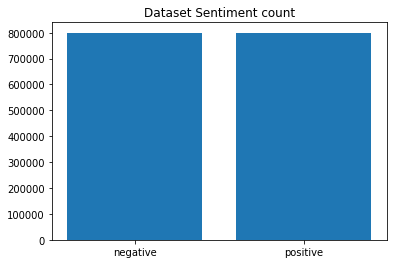

In [9]:
#check the data
df = pd.read_csv(DATASET_FILEPATH,  encoding=DATASET_ENCODING, names=DATASET_FIELDS)
df = df[['target', 'text']]
print(df.head())

# label targets as negative, neutral, positive and display the dataset
targets = Counter(df.target.apply(lambda x: DECODE_MAP[int(x)]))

plt.bar(targets.keys(), targets.values())
plt.title("Dataset Sentiment count")
plt.show()

# 1. Preprocessing datasets

The team decided to preprocess the following from the dataset:

<ul>
  <li>Convert tweets to lower case</li>
  <li>Remove URL links</li>
  <li>Remove @mentions</li>
  <li>Remove # in #hashtags</li>
  <li>Contraction expansion</li>
  <li>Remove special characters</li>
  <li>Remove additional spaces</li>
</ul>

Note: Initially, we converted emoticons to text and removed stop words. However, through testing the accuracy decreased. Therefore, it is not an appropriate preprocessing method when it comes to building a deep learning model for our approach.

In [10]:
def clean_tweet(tweet):
    
    tweet = tweet.lower()

    # remove www/HTTPS/HTTP links & other links
    tweet = re.sub(r'\b(?:(?:https?|ftp)://)?\w[\w-]*(?:\.[\w-]+)+\S*', ' ', tweet)

    # remove mentions
    tweet = re.sub('@[^\s]+','', tweet) 

    # remove # in #hashtags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # expand contractions
    tweet = contractions.fix(tweet)

    # remove any characters that are not a-z
    tweet = re.sub(r'[^a-z]+', ' ', tweet) 

    # remove trailing spaces and additional spaces
    tweet = re.sub(' +', ' ', tweet)
    tweet = tweet.strip() 
    
    return tweet

In [11]:
# apply preprocessing
df.text = df.text.progress_map(lambda x: clean_tweet(x))

## `Split the dataframe into training and test set`

In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_SEED)
print("DF Train size:", len(df_train))
print("DF Test size:", len(df_test))

DF Train size: 1280000
DF Test size: 320000


# 2. Text Representation

Utilizing keras tokenizer to tokenize, convert text to sequences, and pad the sequences

In [13]:
# create tokenizer and fit
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tqdm(df_train.text))

# tokenize the sentences
x_train = tokenizer.texts_to_sequences(tqdm(df_train.text))
x_test = tokenizer.texts_to_sequences(tqdm(df_test.text))

# pad the sentences
x_train = pad_sequences(tqdm(x_train), maxlen=None)
x_test = pad_sequences(tqdm(x_test), maxlen=len(x_train[0]))

## `Encode outputs to 0, 1`

In [14]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 53)
y_train (1280000, 1)

x_test (320000, 53)
y_test (320000, 1)


# 3. Generate Embedding  Matrix

Enables a mapping of words to vectors based on a corpus of text. For the purpose of this notebook, we use two datasets, glove.840B.300d and crawl-300d-2M.vec.



In [15]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
      return dict(get_coefs(*line.strip().split(' ')) for line in f)

# build embedding matrix. 300 due to the dimensions of our inputs being 300
embedding_dim = 300

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    print('Found %s word vectors from: %s.' % (len(embedding_index), path))
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in tqdm(word_index.items()):
      try:
          embedding_matrix[i] = embedding_index[word]
      except KeyError:
          pass
    return embedding_matrix


# concatenate the two resulting word embeddings
embedding_matrix =  np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in tqdm(EMBEDDING_FILES)], axis=-1)    

Found 2000000 word vectors from: crawl-300d-2M.vec.



Found 2196008 word vectors from: glove.840B.300d.txt.


# 4. Modeling

Use a set of layers to build our model including one of the embedding layers we have created.

Note: On Kaggle Notebook we are provided with a TPU which has a 30 hour limit per 3 days. Therefore, our team decided to use the TPU to produce faster modeling results.

In [16]:
# LSTM Model - Baseline. 
def build_model_LSTM(use_pretrained=False):
        embed_dim = 128
        lstm_out = 196
        spatial_dropout_rate = 0.4
        lstm_dropout_rate = 0.2
        model = Sequential()
        if(use_pretrained):
            model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=len(x_train[0])))
        model.add(SpatialDropout1D(spatial_dropout_rate))
        model.add(LSTM(lstm_out, dropout=lstm_dropout_rate, recurrent_dropout=lstm_dropout_rate))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
        return model

# CNN + LSTM Model, improvement over the LSTM model when using trainable embeddings
def build_model_CNN_LSTM(use_pretrained=False):
        filter_size = 200 
        ksize = 3 #kernel size
        dropout_rate = 0.3
        model = Sequential()
        if(use_pretrained):
            model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
        else:
            model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=len(x_train[0])))
        model.add(Conv1D(filters=filter_size, kernel_size=ksize, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(100, recurrent_dropout = dropout_rate, dropout=dropout_rate,))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        return model    

# Proposed model, uses Bidirectional LSTM layers.
def build_model_BiLSTM(use_pretrained=False):
        INPUT_LENGTH = len(x_train[0])
        words = Input(shape=(INPUT_LENGTH,))
        if(use_pretrained):
            embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(words)
        else:
            embedding = Embedding(len(tokenizer.word_index) + 1, 100, input_length=len(x_train[0]))(words)
        bilstm1 = Bidirectional(LSTM(100, return_sequences=True))(embedding)
        dropout = SpatialDropout1D(0.2)(bilstm1)
        bilstm2 = Bidirectional(LSTM(100, return_sequences=True))(dropout)

        hidden = concatenate([
            GlobalMaxPooling1D()(bilstm2),
            GlobalAveragePooling1D()(bilstm2),
        ])

        result = Dense(1, activation='sigmoid')(hidden)
        model = Model(inputs=words, outputs=result)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

## `BiLSTM`

In [17]:
# Optimal Batch Size for BiLSTM : 512
model = build_model_BiLSTM(use_pretrained=True)

# Print out the structure of model
model.summary()

# Use early stopping as a callback function to save best model into best_model.h5
callbacks = [EarlyStopping(monitor='val_loss', patience=0),
             ModelCheckpoint(filepath='BiLSTM_MODEL.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(x_train, y_train,
                    batch_size=512,
                    epochs=10,
                    callbacks=callbacks,
                    validation_split=0.1,
                    verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 53)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 53, 600)      137976000   input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 53, 200)      560800      embedding[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 53, 200)      0           bidirectional[0][0]              
______________________________________________________________________________________________

## `CNN + LSTM`

In [ ]:
# Optimal CNN + LSTM
model = build_model_CNN_LSTM(use_pretrained=True)

# Print out the structure of model
model.summary()

# Use early stopping as a callback function to save best model into best_model.h5
callbacks = [EarlyStopping(monitor='val_loss', patience=0),
             ModelCheckpoint(filepath='CNN_LSTM_MODEL.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(x_train, y_train,
                    batch_size=250,
                    epochs=20,
                    callbacks=callbacks,
                    validation_split=0.1,
                    verbose=1)

## `LSTM`

In [ ]:
# Optimal  LSTM
model = build_model_LSTM(use_pretrained=True)

# Print out the structure of model
model.summary()

# Use early stopping as a callback function to save best model into best_model.h5
callbacks = [EarlyStopping(monitor='val_loss', patience=0),
             ModelCheckpoint(filepath='LSTM.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(x_train, y_train,
                    batch_size=125,
                    epochs=20,
                    callbacks=callbacks,
                    validation_split=0.1,
                    verbose=1)

# 6. Deployment

This step involves prediction and model evaluation

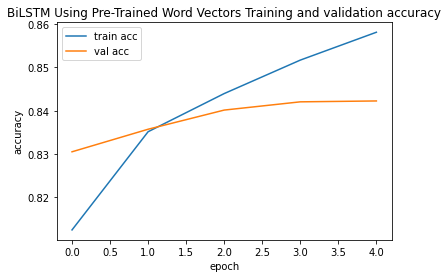

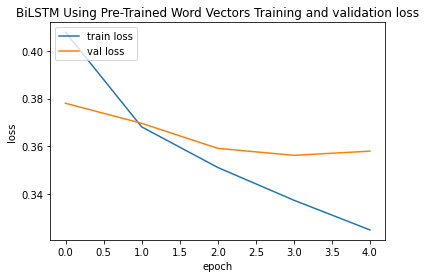

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BiLSTM Using Pre-Trained Word Vectors Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.savefig('PRETRAINED_BiLSTM_val_acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BiLSTM Using Pre-Trained Word Vectors Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.savefig('PRETRAINED_BiLSTM_val_loss.png')
plt.show()


> # **Testing the model on the Test Set**

After the training is done, the best model should have been saved onto 'best_model.h5', we load this model in here and use our test set to validate the accuracy and loss

In [18]:
# Load the model if you want to test a specific model
# model = tf.keras.models.load_model('CNN_LSTM_MODEL.h5')

# Evaluate the model
results = model.evaluate(x_test, y_test, batch_size=512)

320000/320000 [==============================] - 331s 1ms/sample - loss: 0.3559 - accuracy: 0.8430


# **Use the code below to make predictions using the trained model**



*   Produces an input to input a sentence
*   Converts it to sequences and does padding using the tokenizer.
*   Does prediction using model.predict
*   Classifies based on result of model.predict



In [48]:
def pre_process(text):
  text = clean_tweet(text)
  text = [text]
  sq = tokenizer.texts_to_sequences((text))
  padded = pad_sequences((sq), maxlen=len(x_train[0]))
  return padded

def prediction():
  text = input()
  text = pre_process(text)
  score = model.predict(text)

  if score < 0.4:
      print("NEGATIVE?")
  elif score > 0.6:
      print("POSITIVE")
  else:
      print("NEUTRAL")
  
  print("Score" + str(score[0]))

prediction()

 We should fulfill the eternal dream and great goal of vanishing humanity


POSITIVE
Score[0.9384825]
